In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew, rankdata
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from sklearn.preprocessing import StandardScaler

## DATA PREP

In [2]:
# Load the CSV files using pandas
df = pd.read_csv('compiled_fixations.csv', index_col=0)
df_random_noise = pd.read_csv('compiled_fixations-with-noise.csv', index_col=0)
# Participant information
ptinfo = pd.read_csv('participant_info.csv', index_col=0)

In [3]:
# Create a Series for variables using Id as the index
dob_series = ptinfo.set_index('ID')['DoB']
gender_series = ptinfo.set_index('ID')['Gender']
valid_series = ptinfo.set_index('ID')['Valid']

# Map the dob values to df based on 'id'
df['dob'] = df['ID'].map(dob_series)

df['gender'] = df['ID'].map(gender_series)

df['valid'] = df['ID'].map(valid_series)

df_random_noise['dob'] = df_random_noise['ID'].map(dob_series)

df_random_noise['gender'] = df_random_noise['ID'].map(gender_series)

df_random_noise['valid'] = df_random_noise['ID'].map(valid_series)

# Calculate the age of each participant
df['age'] = 2023 - df['dob']
df_random_noise['age'] = 2023 - df_random_noise['dob']


## Descriptive Analysis

In [4]:
df.describe()

,index,onset,duration,offset,avg_x,avg_y,ID,Order,dob,age
count,183627.000000,183627.000000,183627.000000,183627.000000,183627.000000,183627.000000,1.836270e+05,183627.000000,183627.000000,183627.000000
mean,25.755112,4.541382,0.256772,4.798153,917.434451,522.933912,2.023072e+16,12.567166,1994.486198,28.513802
std,16.214416,2.804168,0.200679,2.818708,504.396585,321.771512,2.369701e+11,7.917095,12.072294,12.072294
min,0.000000,0.009000,0.015000,0.092000,-110.780000,0.000000,2.023031e+16,0.000000,1930.000000,3.000000
25%,12.000000,2.085000,0.134000,2.335000,446.205000,222.200000,2.023051e+16,6.000000,1988.000000,22.000000
50%,25.000000,4.471000,0.200000,4.737000,899.580000,510.550000,2.023072e+16,12.000000,1999.000000,24.000000
75%,38.000000,6.940000,0.316500,7.223500,1340.715000,815.430000,2.023092e+16,19.000000,2001.000000,35.000000
max,83.000000,9.909000,6.874000,9.927000,2030.780000,1329.260000,2.023112e+16,40.000000,2020.000000,93.000000


In [5]:
print(len(df))
print(len(df_random_noise))
print(len(ptinfo))

183627
69329
9405


Text(0.5, 1.0, 'Histogram of fixation duration')

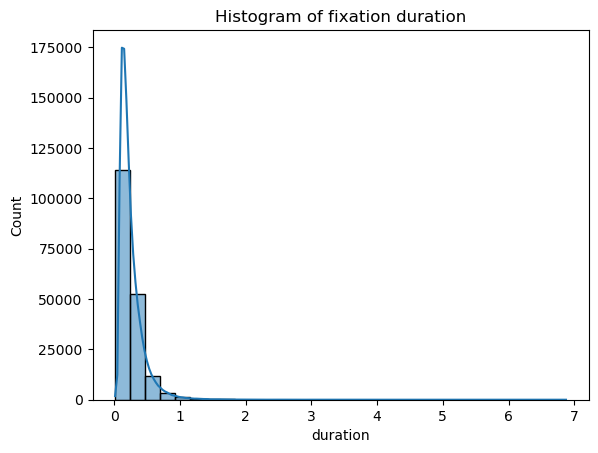

In [6]:
# Plot histogram of fixation duration
sns.histplot(df['duration'], bins=30, kde=True)
plt.title("")
plt.savefig('hist-plot.pdf')
plt.title('Histogram of fixation duration')


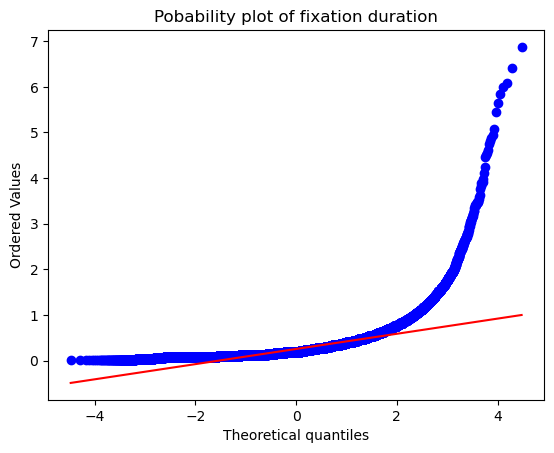

In [7]:
stats.probplot(df['duration'], plot=plt)
plt.title("")
plt.savefig('qq-plot.pdf')
plt.title('Pobability plot of fixation duration')
plt.show()

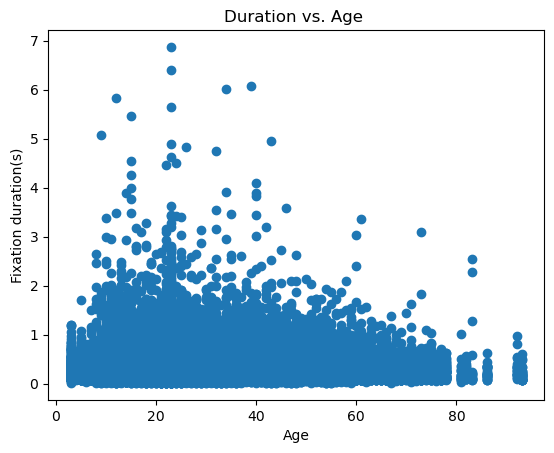

In [8]:
plt.scatter(df['age'],df['duration'])
plt.title("")
plt.xlabel('Age')
plt.ylabel('Fixation duration(s)')
plt.savefig('fixation_vs_duration.pdf')
plt.title('Duration vs. Age ')
plt.show()

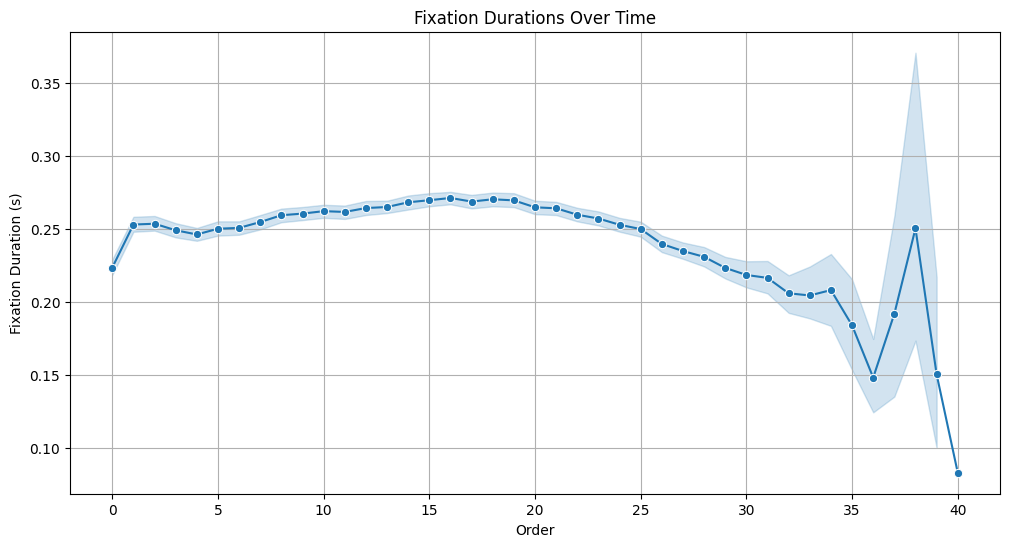

In [9]:
# Plot the original data
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Order', y='duration', marker='o', label='')
plt.title('')
plt.xlabel('Order')
plt.ylabel('Fixation Duration (s)')
plt.savefig('line-plot.pdf')
plt.title('Fixation Durations Over Time')
plt.grid(True)
plt.show()

## Relationships between fixation duration, age and time
- Age is treated as a continuous variable scaled to have mean zero and standard deviation of one, so the model can easily converge
- Order is treated as a qualitative variable so it is not scaled, to maintain the order.
- The Mixedlm package does not allow for a family other than the normal distribution, so the duration is transformed from an inverse normal to have a normal distribution to fit the model.

In [9]:
# Initialize the scaler
scaler = StandardScaler()

df['ID'] = df['ID'].astype(str)
df['Order_sq'] = df['Order'] ** 2 

# Scale the age column
df['age_scaled'] = scaler.fit_transform(df[['age']])

print(df.head())

   index label  onset  duration  offset    avg_x    avg_y                 ID  \
0      0  FIXA  0.019     0.350   0.369   677.43   726.93  20230314113311129   
1      2  FIXA  0.435     0.434   0.869   985.40   720.16  20230314113311129   
2      4  FIXA  0.936     0.151   1.087   715.11   928.30  20230314113311129   
3      6  FIXA  1.137     0.267   1.404   761.39  1026.49  20230314113311129   
4      8  FIXA  1.471     0.232   1.703  1201.48  1147.63  20230314113311129   

   Order   dob gender  valid  age  Order_sq  age_scaled  
0      0  1989   MALE   True   34         0    0.454447  
1      1  1989   MALE   True   34         1    0.454447  
2      2  1989   MALE   True   34         4    0.454447  
3      3  1989   MALE   True   34         9    0.454447  
4      4  1989   MALE   True   34        16    0.454447  


In [10]:
# Apply the inverse normal transformation
df['duration_norm'] = norm.ppf((rankdata(df['duration'], method='average') - 0.5) / len(df['duration']))

# Mixed Effects Model
model_inverse_normal = mixedlm(
    'duration_norm ~ age_scaled + Order + Order_sq',
    df,
    groups=df['ID']
)
result_inverse_normal = model_inverse_normal.fit(maxiter=1000)
# Summary
print(result_inverse_normal.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: duration_norm
No. Observations: 183627  Method:             REML         
No. Groups:       7250    Scale:              0.9560       
Min. group size:  1       Log-Likelihood:     -258814.1027 
Max. group size:  41      Converged:          Yes          
Mean group size:  25.3                                     
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.153     0.006  -23.983  0.000  -0.166  -0.141
age_scaled  -0.004     0.003   -1.261  0.207  -0.010   0.002
Order        0.025     0.001   24.542  0.000   0.023   0.027
Order_sq    -0.001     0.000  -17.690  0.000  -0.001  -0.001
Group Var    0.035     0.001                                



### Check for model assumption

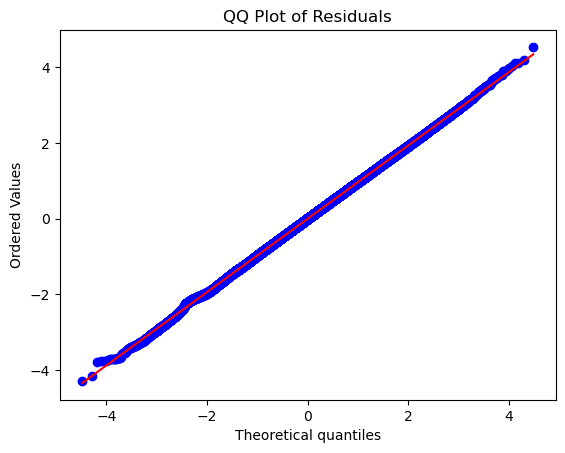

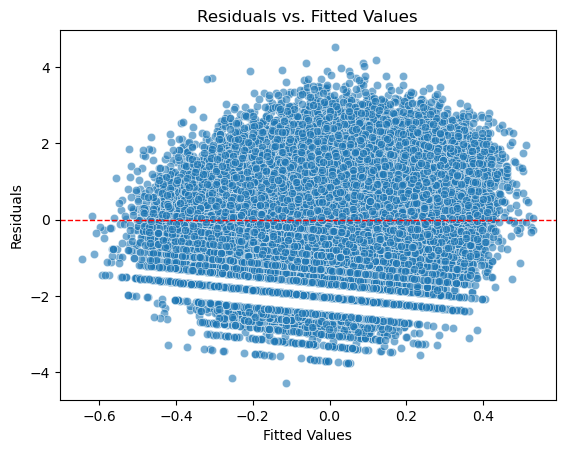

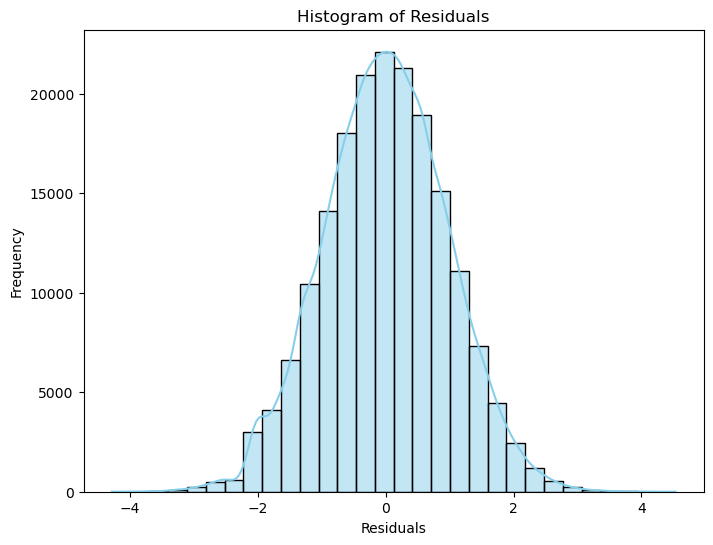

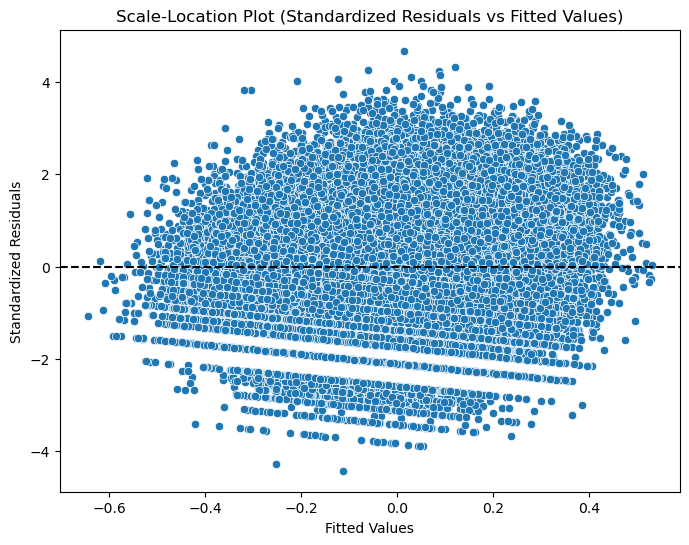

In [11]:
from statsmodels.stats.outliers_influence import OLSInfluence
# Calculate residuals
residuals = result_inverse_normal.resid
fitted_values = result_inverse_normal.fittedvalues

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("")
plt.savefig('model_qq.pdf') 
plt.title('QQ Plot of Residuals')
plt.show()

sns.scatterplot(x=fitted_values, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("")
plt.savefig('model_residual.pdf') 
plt.title("Residuals vs. Fitted Values")


# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue', bins=30)
plt.title("")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig("model_hist.pdf")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location Plot (Standardized Residuals vs Fitted Values)
# Standardized residuals
standardized_residuals = residuals / np.std(residuals)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title("")
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.savefig("scaled.pdf")
plt.title("Scale-Location Plot (Standardized Residuals vs Fitted Values)")
plt.show()

## ROBUSTNESS ANALYSIS

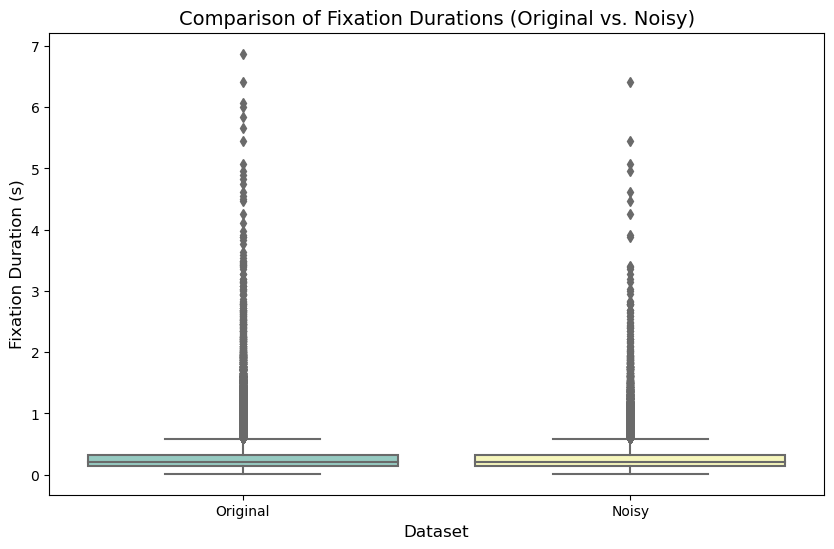

In [18]:
original_durations = df['duration']
augmented_durations = df_random_noise['duration']

# Create a new dataframe with the fixation durations and their corresponding dataset labels
original_durations_df = pd.DataFrame({
    'Fixation Duration': original_durations,
    'Dataset': 'Original'
})

augmented_durations_df = pd.DataFrame({
    'Fixation Duration': augmented_durations,
    'Dataset': 'Noisy'
})

# Combine the durations into one dataframe
combined_data = pd.concat([original_durations_df, augmented_durations_df], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dataset', y='Fixation Duration', data=combined_data, palette='Set3')

# Add labels and title
plt.title(" ")
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Fixation Duration (s)', fontsize=12)
plt.savefig("boxplot.pdf")
plt.title('Comparison of Fixation Durations (Original vs. Noisy)', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Histogram')

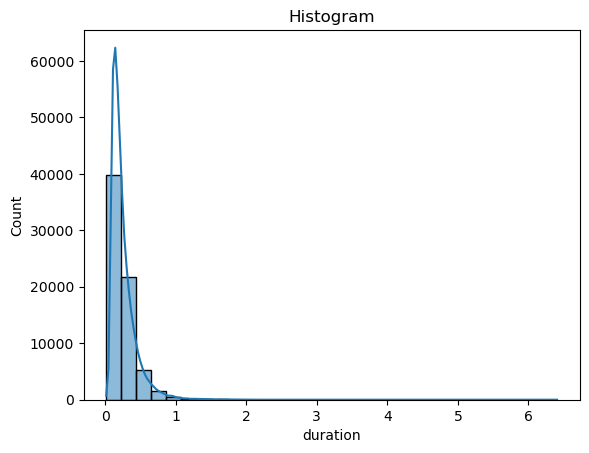

In [13]:
# Plot histogram of fixation duration
sns.histplot(df_random_noise['duration'], bins=30, kde=True)
plt.title("")
plt.savefig('histn-plot.pdf')
plt.title("Histogram")

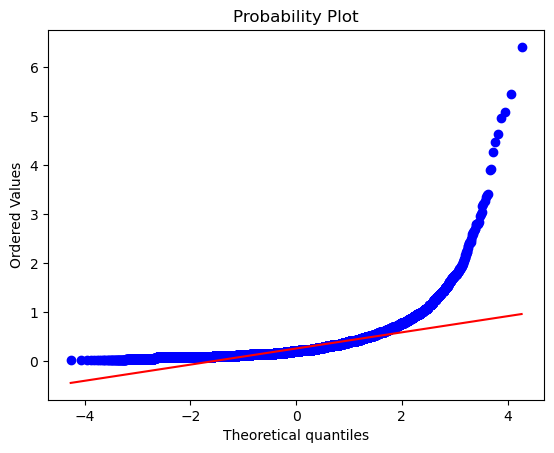

In [14]:
stats.probplot(df_random_noise['duration'], plot=plt)
plt.show()

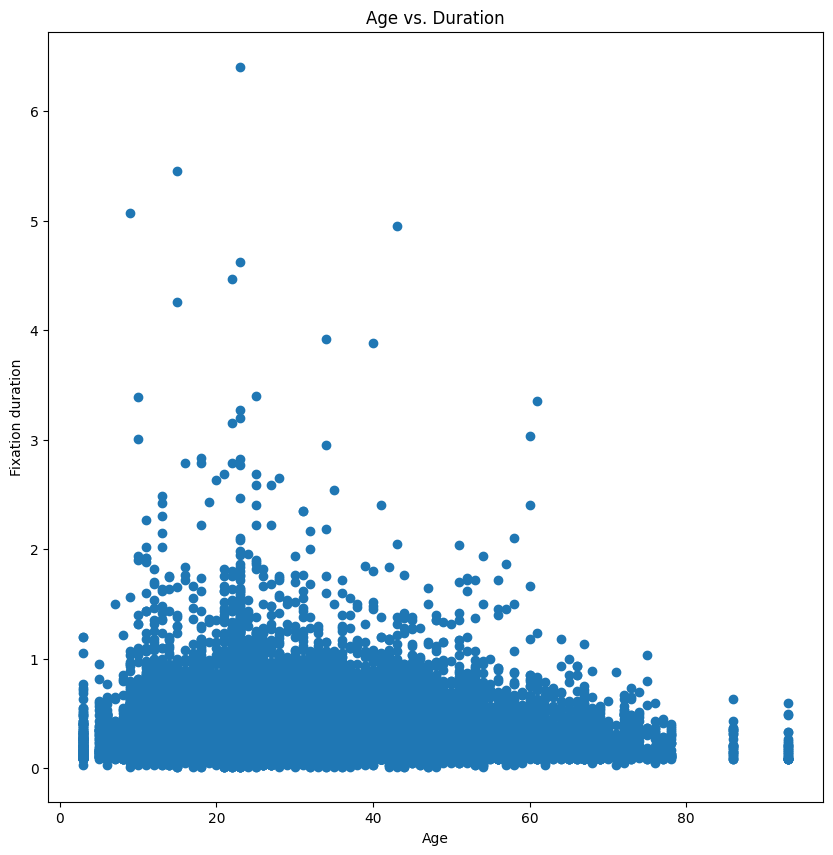

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(df_random_noise['age'], df_random_noise['duration'])
plt.title("")
plt.xlabel('Age')
plt.ylabel('Fixation duration')
plt.savefig("scattern.pdf")
plt.title('Age vs. Duration')
plt.show()

In [15]:
# Initialize the scaler
scaler = StandardScaler()

df_random_noise.loc[:, 'ID'] = df_random_noise['ID'].astype(str)
df_random_noise.loc[:, 'Order_sq'] = df_random_noise['Order'] ** 2


# Scale the age column
df_random_noise.loc[:, 'age_scaled'] = scaler.fit_transform(df_random_noise[['age']])

print(df_random_noise.head())

   index  Unnamed: 0 label  onset  duration  offset    avg_x    avg_y  \
0      0           0  FIXA  0.019     0.350   0.369   677.43   726.93   
1      2           2  FIXA  0.435     0.434   0.869   985.40   720.16   
2      4           4  FIXA  0.936     0.151   1.087   715.11   928.30   
3      6           6  FIXA  1.137     0.267   1.404   761.39  1026.49   
4      8           8  FIXA  1.471     0.232   1.703  1201.48  1147.63   

                  ID  Order   dob gender  valid  age  Order_sq  age_scaled  
0  20230314113311129      0  1989   MALE   True   34         0    0.438889  
1  20230314113311129      1  1989   MALE   True   34         1    0.438889  
2  20230314113311129      2  1989   MALE   True   34         4    0.438889  
3  20230314113311129      3  1989   MALE   True   34         9    0.438889  
4  20230314113311129      4  1989   MALE   True   34        16    0.438889  


In [16]:
# Apply the inverse normal transformation

df_random_noise.loc[:, 'duration_norm'] = norm.ppf((rankdata(df_random_noise['duration'], method='average') - 0.5) / len(df_random_noise['duration']))
# Fit a Linear Mixed Effects Model
model_inverse_normal_noise = mixedlm(
    'duration_norm ~ age_scaled + Order + Order_sq',
    df_random_noise,
    groups=df_random_noise['ID']
)
result_inverse_normal_noise = model_inverse_normal_noise.fit()
# Summary
print(result_inverse_normal_noise.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: duration_norm
No. Observations: 69329   Method:             REML         
No. Groups:       2724    Scale:              0.9561       
Min. group size:  3       Log-Likelihood:     -97724.1508  
Max. group size:  41      Converged:          Yes          
Mean group size:  25.5                                     
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.153     0.010  -14.724  0.000  -0.173  -0.133
age_scaled  -0.002     0.005   -0.396  0.692  -0.012   0.008
Order        0.025     0.002   15.213  0.000   0.022   0.028
Order_sq    -0.001     0.000  -11.102  0.000  -0.001  -0.001
Group Var    0.035     0.002                                



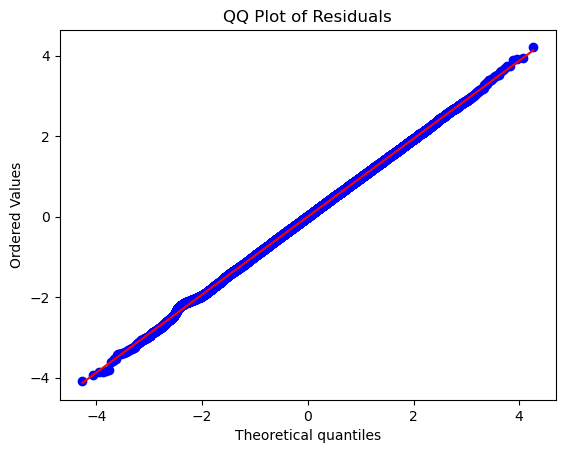

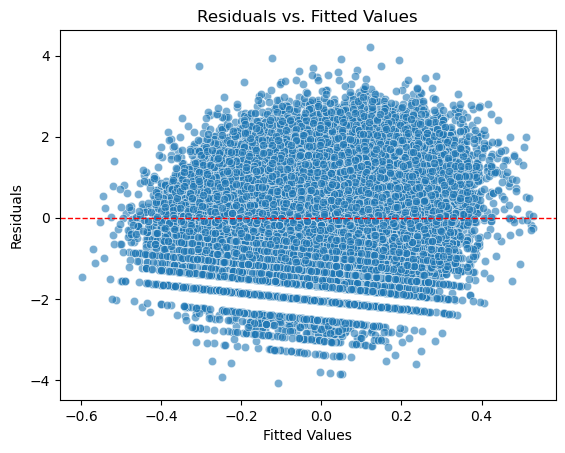

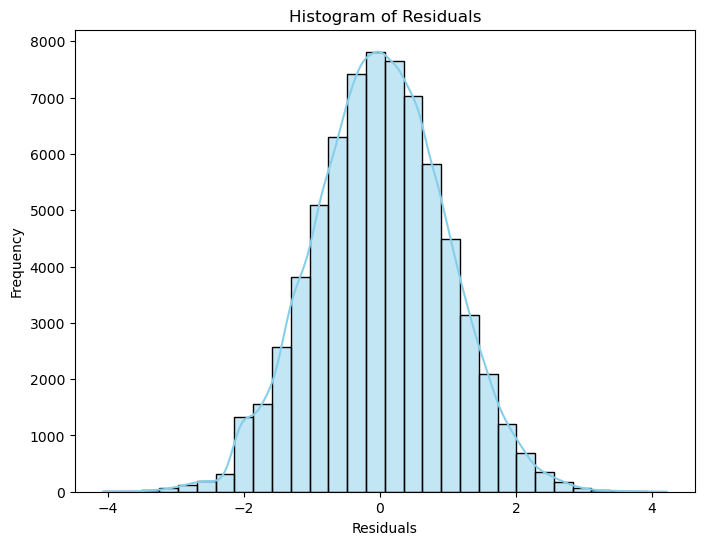

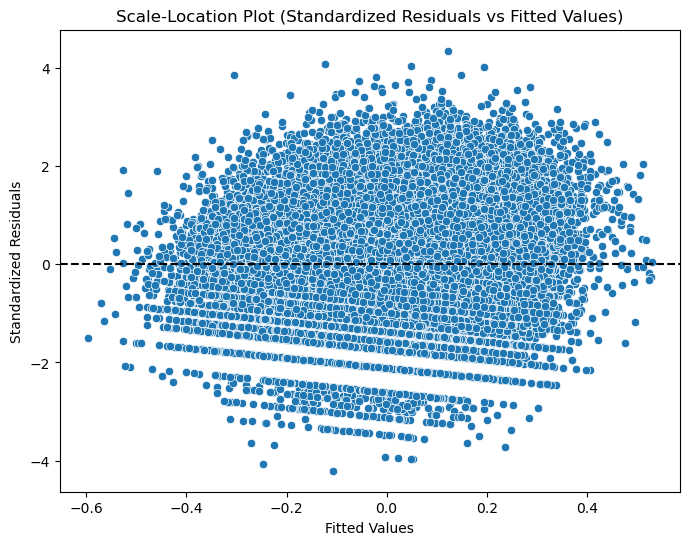

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence
# Calculate residuals
residuals = result_inverse_normal_noise.resid
fitted_values = result_inverse_normal_noise.fittedvalues

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("")
plt.savefig('model_qqn.pdf') 
plt.title('QQ Plot of Residuals')
plt.show()

sns.scatterplot(x=fitted_values, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(" ")
plt.savefig('residualn.png') 
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")




# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue', bins=30)
plt.title("")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig("hist_resn.pdf")
plt.title("Histogram of Residuals")
plt.show()

# 4. Scale-Location Plot (Standardized Residuals vs Fitted Values)
# Standardized residuals
standardized_residuals = residuals / np.std(residuals)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title("")
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.savefig("scaledn.pdf")
plt.title("Scale-Location Plot (Standardized Residuals vs Fitted Values)")
plt.show()